In [647]:
#Librarires and functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import Video

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.arena.tethered import Tethered
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork

from gymnasium import spaces
from gymnasium.utils.env_checker import check_env

In [648]:
#Implementing a standard tripod gait
_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

In [649]:
#Implementing a windy arena with a laminar wind
from dm_control.mjcf.physics import Physics


class WindArena(FlatTerrain):
    def __init__(
        self,
        #Change wind direction here
        wind_vector=[ -1, 3, 0],
        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here I directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)
    

wind_arena = WindArena()

In [650]:
from typing import Any, Dict, Tuple

class WindTurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)
    
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            #elif "Arista" in joint.name:
                #joint.stiffness = 0.002
                #joint.damping = 1e-5
            elif "LArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "RArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "Head" in joint.name:
                joint.stiffness = 1000.0
                joint.damping = 1000.0
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping
            
    def _add_joint_sensors(self):
        self._arista_sensors = []
        self._debug_end_effectors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_torque = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )
            self._arista_sensors.append(arista_sensor_torque)
            self._arista_sensors.append(arista_sensor_joint)            

        return super()._add_joint_sensors()
    
    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        
        return obs
    
    def _define_observation_space(self):
        _observation_space = {
            "joints": spaces.Box(
                low=-np.inf, high=np.inf, shape=(3, len(self.actuated_joints))
            ),
            "fly": spaces.Box(low=-np.inf, high=np.inf, shape=(4, 3)),
            "contact_forces": spaces.Box(
                low=-np.inf, high=np.inf, shape=(len(self.contact_sensor_placements), 3)
            ),
            # x, y, z positions of the end effectors (tarsus-5 segments)
            "end_effectors": spaces.Box(low=-np.inf, high=np.inf, shape=(6, 3)),
            "fly_orientation": spaces.Box(low=-np.inf, high=np.inf, shape=(3,)),
            "arista_joint_pos": spaces.Box(low=-np.inf, high=np.inf, shape=(4,))
        }
        if self.sim_params.enable_vision:
            _observation_space["vision"] = spaces.Box(
                low=0,
                high=255,
                shape=(2, self._mujoco_config["vision"]["num_ommatidia_per_eye"], 2),
            )
        if self.sim_params.enable_olfaction:
            _observation_space["odor_intensity"] = spaces.Box(
                low=0,
                high=np.inf,
                shape=(self.arena.odor_dimensions, len(self._antennae_sensors)),
            )
        return spaces.Dict(_observation_space)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        #Reset the obs by hand
        obs["arista_joint_pos"] = np.zeros((4,))
        return obs, info

    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

windturning_nmf = WindTurningNMF(Parameters())
windturning_nmf._arista_sensors

[MJCF Element: <jointactuatorfrc name="jointactuatorfrc_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointpos name="jointpos_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointactuatorfrc name="jointactuatorfrc_RArista" joint="joint_RArista"/>,
 MJCF Element: <jointpos name="jointpos_RArista" joint="joint_RArista"/>]

In [651]:
run_time = 5

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",

    #render_camera="Animat/camera_front_zoomin",
    render_playspeed=0.5,
    enable_adhesion=True
)

nmf = WindTurningNMF(
    sim_params = sim_params,
    arena = WindArena(),
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0,0,0.2),
    #when i change spawn orient camera angle change as well
)

#check_env(nmf)

In [652]:
#nmf.reset()[0]

In [653]:
obs_list = []
magnitude_hist = []
end_effector_L = []
end_effector_R = []

AverageWindowL = np.array([])
AverageWindowR = np.array([])

target_num_steps = int(run_time / nmf.timestep)

obs, info = nmf.reset(seed=0)

for i in trange(target_num_steps) :
    curr_time = i * nmf.sim_params.timestep #might be useless
    #if((L-R)>0.010):
    #  action=np.array([1, 0.2])
    #if((L-R)<-0.010):
    #  action=np.array([0.1, 1])

    L = obs["arista_joint_pos"][1]
    R = obs["arista_joint_pos"][3]

    if((L-R)>0.006) :
        action=np.array([1, 0.2])
    else :
        action = np.array([1, 1])
    
    
    obs, reward, terminated, truncated, info = nmf.step(action)

    AverageWindowL=np.append(AverageWindowL,obs["arista_joint_pos"][1])
    AverageWindowR=np.append(AverageWindowR,obs["arista_joint_pos"][3])

    if(len(AverageWindowL)>=2000):
       AverageWindowL=np.delete(AverageWindowL,0)
       AverageWindowR=np.delete(AverageWindowR,0)

    obs["arista_joint_pos"][1]=np.mean(AverageWindowL)
    obs["arista_joint_pos"][3]=np.mean(AverageWindowR)


    obs_list.append(obs)    


    end_effector_L.append(nmf.physics.named.data.qpos[f"Animat/joint_LArista"].copy())
    end_effector_R.append(nmf.physics.named.data.qpos[f"Animat/joint_RArista"].copy())
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

    nmf.render()


nmf.save_video("arista.mp4", 0)


100%|██████████| 50000/50000 [02:35<00:00, 322.01it/s]


In [654]:
obs_list[0].keys()
#observation space parametre de neuromechfly 

dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation', 'arista_joint_pos'])

In [655]:
obs["arista_joint_pos"].shape

(4,)

In [656]:
jnt = nmf.physics.model.jnt("Animat/joint_LArista")
print(jnt.stiffness, jnt.axis, nmf.physics.model.id2name(jnt.bodyid, "body"))

jnt2 = nmf.physics.model.jnt("Animat/joint_RArista")
print(jnt2.stiffness, jnt2.axis, nmf.physics.model.id2name(jnt2.bodyid, "body"))

[0.006] [0. 1. 0.] Animat/LArista
[0.006] [0. 1. 0.] Animat/RArista


In [657]:
qpos = nmf.physics.named.data.qpos["Animat/joint_LArista"]
print(qpos)

qpos = nmf.physics.named.data.qpos["Animat/joint_RArista"]
print(qpos)
#qpos l'angle par rapport origin spawn

[-0.13738684]
[-0.14210867]


In [658]:
Video("./arista.mp4")

In [659]:

#mujoco exclue les collisions entre parents et enfants car souvent liés 
'''3 segments d'antennes
pas symétrique, pos avant la physique attachées pas sym

osef pas sym continue bosser

arista attaché parfaitement sym relatif au parent parfait
mesh aussi parfaitement symétrique
2 mais :
- problèmes bizarres avec les mesh (Strucutres de tt les élems) mesh mirror marchait bien pour les pattes  devrait être ok
- tête pas sym -> plan de sym de la tête pas le 0 du fichier, une antenne + attaché à gauche ou droite donc delta longeur centre de rotation change torque
pourrait test en shiftant les antennes d'un coté
-Contacts chelous entre les 3 bails de l'arista qui rentre dans le péniculus avec le pédicel les deux se rentrent dedans et l'un bloque l'autre

avant ligne 489 du core flygym get body 
flygym/mujoco/flygym/

QUAND RAJOUTE JOINT AU XML AJOUTE CETTE LIGNE POUR BOUGER L'ARISTAE POUR VOIR CE QUÎL SE PASSE
self.model.find("geom","LArista").pos donne geom et modif posigion
'''

'3 segments d\'antennes\npas symétrique, pos avant la physique attachées pas sym\n\nosef pas sym continue bosser\n\narista attaché parfaitement sym relatif au parent parfait\nmesh aussi parfaitement symétrique\n2 mais :\n- problèmes bizarres avec les mesh (Strucutres de tt les élems) mesh mirror marchait bien pour les pattes  devrait être ok\n- tête pas sym -> plan de sym de la tête pas le 0 du fichier, une antenne + attaché à gauche ou droite donc delta longeur centre de rotation change torque\npourrait test en shiftant les antennes d\'un coté\n-Contacts chelous entre les 3 bails de l\'arista qui rentre dans le péniculus avec le pédicel les deux se rentrent dedans et l\'un bloque l\'autre\n\navant ligne 489 du core flygym get body \nflygym/mujoco/flygym/\n\nQUAND RAJOUTE JOINT AU XML AJOUTE CETTE LIGNE POUR BOUGER L\'ARISTAE POUR VOIR CE QUÎL SE PASSE\nself.model.find("geom","LArista").pos donne geom et modif posigion\n'

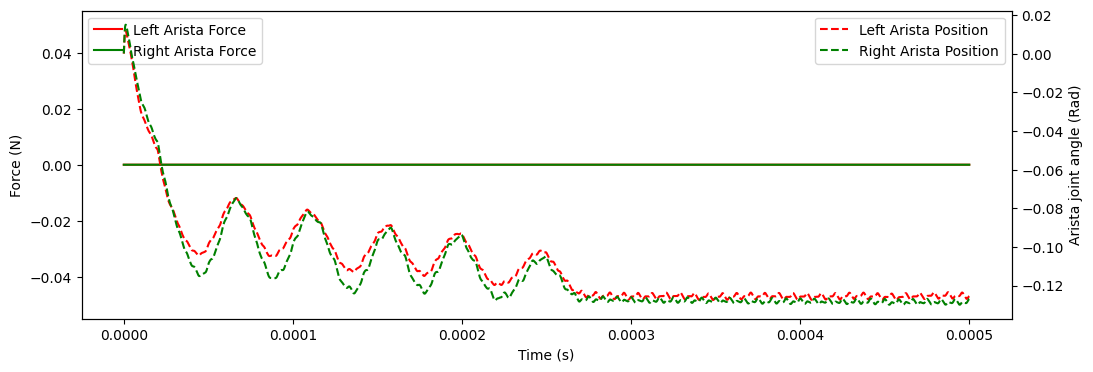

In [660]:
arista_joint = np.array([obs["arista_joint_pos"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * nmf.timestep

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotting the first and third curves on the left y-axis
ax1.plot(time, arista_joint[:, 0], 'r',label="Left Arista Force")
#ax1.plot(time, arista_joint[:, 2]-0.00022,'g', label="Right Arista Force")
ax1.plot(time, arista_joint[:, 2],'g', label="Right Arista Force")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Force (N)')
ax1.legend(loc='upper left')

# Create a second y-axis for the second and fourth curves
ax2 = ax1.twinx()
ax2.plot(time, arista_joint[:, 1], 'r--', label="Left Arista Position")
#ax2.plot(time, arista_joint[:, 3]-0.2, 'g--', label="Right Arista Position")
ax2.plot(time, arista_joint[:, 3], 'g--', label="Right Arista Position")
ax2.set_ylabel('Arista joint angle (Rad)')
ax2.legend(loc='best')

plt.show()

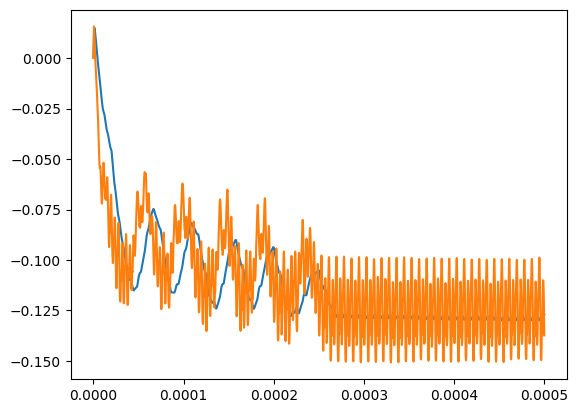

In [661]:
plt.plot(time,arista_joint[:, 3])
plt.plot(time, np.array(end_effector_L))

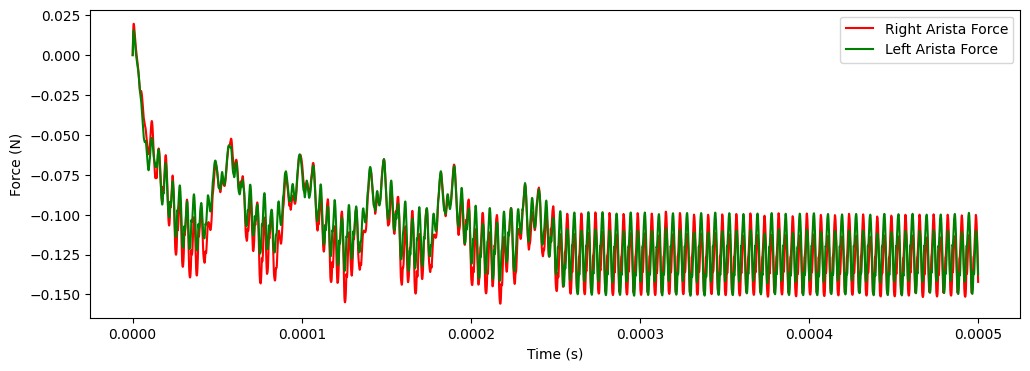

In [662]:
#arista_joint = np.array([obs["arista_end_eff"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * nmf.timestep

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotting the first and third curves on the left y-axis
ax1.plot(time, np.array(end_effector_R), 'r',label="Right Arista Force")
ax1.plot(time, np.array(end_effector_L),'g', label="Left Arista Force")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Force (N)')
ax1.legend(loc='best')

In [663]:
#Still diff between 5,5,0 and -5,-5,0 ???? WHY GOD WHY l'antenne de gauche de la mouche bouge tjrs +
#mdr c'est my bad j'avais oublié de rechanger la stiffness
#mtn avec même stiffness bien égal yipee

In [664]:
arista_joint[:, 1].shape

(50000,)

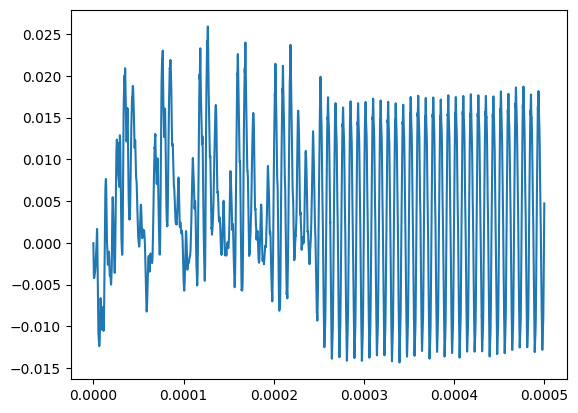

In [665]:
plt.plot(time,(np.array(end_effector_L) - np.array(end_effector_R))) #0.30 max diff wind 0 #0.4 max diff with 2-20
#moyenne passante to

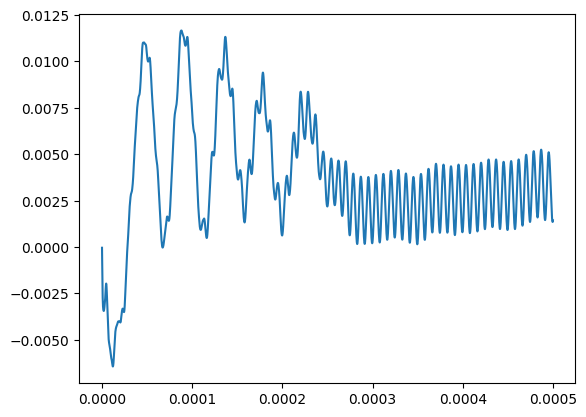

In [666]:
plt.plot(time,(np.array(arista_joint[:, 1]) - np.array(arista_joint[:, 3])))

In [667]:
(np.array(end_effector_R) - np.array(end_effector_L))[-1]

array([-0.00472184])

In [668]:
fly = np.array([obs["fly"] for obs in obs_list])

In [669]:
fly.shape

(50000, 4, 3)

In [670]:
fly_orient_x = fly[:,2,0]
fly_orient_y = fly[:,2,1]
fly_orient_z = fly[:,2,2]

In [671]:
np.ones(500000).shape

(500000,)

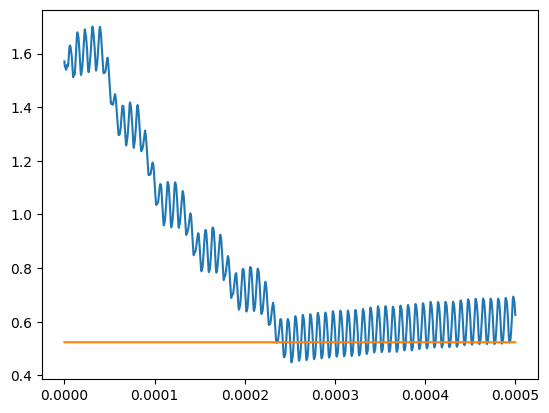

In [672]:
plt.plot(time,fly_orient_x)
plt.plot(time,np.ones(len(time))*(np.pi/6))

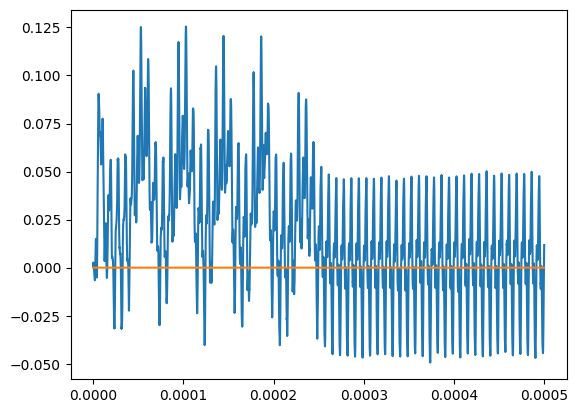

In [673]:
plt.plot(time,fly_orient_y)
plt.plot(time,np.zeros(len(time)))

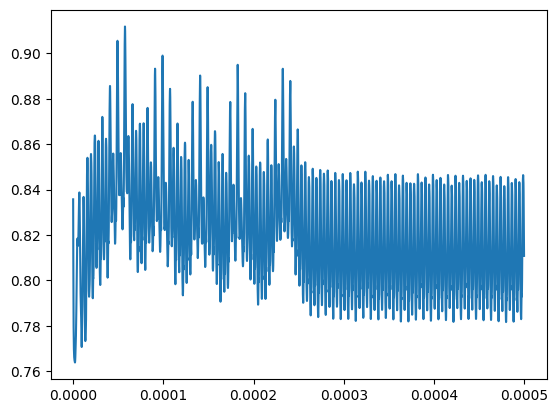

In [674]:
plt.plot(time,fly_orient_z)


In [675]:
#spawn plein de mouches plein de dir pour voir si marche bien

#rotation around x y z axis in radians
#default = 0,0,0 -> fonce en x 0, y 0 
#0,0,pi/2 x va à pi/2 les autres changent pas
#only look at x ?